In [19]:
import pandas as pd
import seaborn as sns
import os 
import sklearn as sk
import matplotlib.pyplot as plt

In [20]:
df_dict = {}

# load data
for file in os.listdir("../final_data"):
   if file.endswith(".tsv"):
        filename = os.path.splitext(os.path.basename(file))[0]
        print(filename)
        temp_df = pd.read_csv(os.path.join('../final_data', file), delimiter='\t')
        df_dict[filename] = temp_df

fun
proff
bowls
jewel
papyrus
games
toil
furn
met
boxbas
shabtis
amph
cost
pers
jars
coffins
fertil
lotus_converted


In [21]:
from sklearn.preprocessing import StandardScaler
# set up cost dataframe for kmeans clustering 
cost_df = df_dict['cost']

# since coffins column is missing values, add the coffin column from coffins.tsv
coffins_df = df_dict['coffins']
merged_df = cost_df.merge(coffins_df, left_on="coffins", right_on="total_cost", how="left")
cost_df["coffins"] = cost_df["coffins"].fillna(merged_df["coffins"])

# some of the missing values have different keys - filling in manually
# found this value in coffins_df
cost_df.at[0, "coffins"] = 590.0
# cannot find k&m in coffins_df, in paper, it says that Kha and Merit are similar to Yuya and Tuya, so filling their coffin value wih 590
cost_df.at[2, "coffins"] = 590.0

# filling in missing jewelry values
jewel_df = df_dict['jewel']
# putting 0 for iabtina because appendix in paper says there is no jewelry
cost_df.at[25, "jewlery"] = 0
# cannot find data for NuMan, putting 85 which is the average of the rank above and rank below cost on jewelry
cost_df.at[75, "jewlery"] = 85
cost_df = cost_df.rename(columns = {"jewlery" : "jewelry"})

# filling in missing values for profess
proff_df = df_dict['proff']
# no professional equipment for Sat-Re, filling in 0
cost_df.at[29, "profess"] = 0

# filling in missing values for toiletries 
# no information about toiletries for Khay, filling in the average of the rank above and below
cost_df.at[5, "toiletries"] = 13.5
# drop some repeat tombs
cost_df = cost_df[~cost_df['tomb'].isin(['Yuya','Kha', 'Merit', "Tuya", "T&A"])]


print(cost_df.isnull().sum())

# drop rank because it was determined by Dr. Smith, dropping tomb because it is just the identifier and a string
feature_matrix = cost_df.drop(['tomb', 'rank'], axis=1)

# scale feature
feature_matrix = StandardScaler().fit_transform(feature_matrix)


tomb           0
rank           0
grand_total    0
amphorae       0
bouquet        0
bowls          0
boxbas         0
coffins        0
fertility      0
funerary       0
furniture      0
jars           0
jewelry        0
personal       0
profess        0
shabti         0
toiletries     0
vessels        0
dtype: int64


In [22]:
from sklearn.decomposition import PCA

# create PCA features
pca = PCA(n_components=2)
feature_matrix = pca.fit_transform(feature_matrix)

In [23]:
from sklearn.cluster import KMeans

# run kmeans clustering on feature matrix
# five clusters because of five socioeconomic statuses: low status, middle status, high middle status, elite, tutankhamen
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(feature_matrix)
cost_df["cluster"] = kmeans.labels_

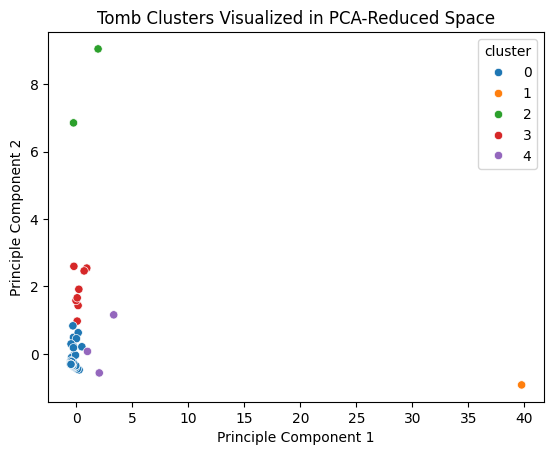

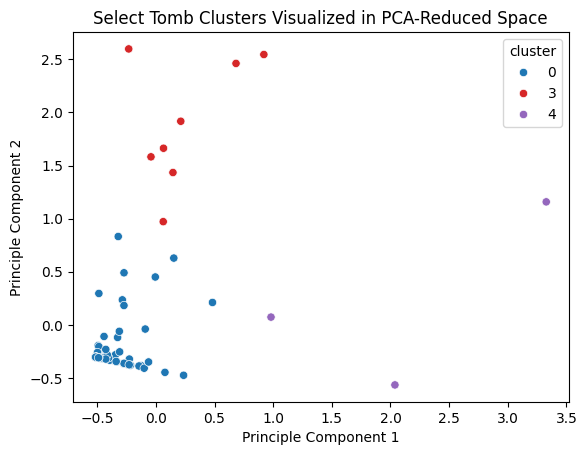

In [24]:
# assign cluster labels 
fm_df = pd.DataFrame(feature_matrix)
fm_df['cluster'] = kmeans.labels_
fm_df.columns = ['feature1', 'feature2', 'cluster']

# sort clusters and assign colors for plotting
cluster_order = sorted(fm_df['cluster'].unique())
base_palette = sns.color_palette('tab10', len(cluster_order))
cluster_colors = {c: base_palette[i] for i, c in enumerate(cluster_order)}

# plot clusters
sns.scatterplot(data=fm_df, x='feature1', y='feature2', hue='cluster',
                palette=cluster_colors, hue_order=cluster_order)
plt.title('Tomb Clusters Visualized in PCA-Reduced Space')
plt.ylabel('Principle Component 2')
plt.xlabel('Principle Component 1')
plt.show()

# filter and plot corner clusters to see them better
filtered = fm_df[~fm_df['cluster'].isin([1, 2])]
cluster_order_subset = [0, 3, 4]  # subset only changes order

plt.clf()
sns.scatterplot(data=filtered, x='feature1', y='feature2', hue='cluster',
                palette=cluster_colors, hue_order=cluster_order_subset)
plt.title('Select Tomb Clusters Visualized in PCA-Reduced Space')
plt.ylabel('Principle Component 2')
plt.xlabel('Principle Component 1')
plt.show()
plt.show()


In [25]:
# save output
display_df = cost_df.filter(['tomb', 'cluster'], axis=1)
display_df.to_csv("kmeans_output.csv", index=False)

In [26]:
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle
from reportlab.lib.pagesizes import letter
from reportlab.lib import colors

# save output as neat pdf for presentation/easy reading 

df = pd.read_csv('kmeans_output.csv')
clusters = sorted(df['cluster'].unique())
lists = [df[df['cluster']==c]['tomb'].tolist() for c in clusters]
max_len = max(len(lst) for lst in lists)
table_data = [[str(c) for c in clusters]]
for i in range(max_len):
    row = [(lists[j][i] if i < len(lists[j]) else '') for j in range(len(clusters))]
    table_data.append(row)
doc = SimpleDocTemplate('clusters_table.pdf', pagesize=letter)
table = Table(table_data)
style = TableStyle([('GRID', (0,0), (-1,-1), 1, colors.black), ('BACKGROUND', (0,0), (-1,0), colors.grey)])
table.setStyle(style)
doc.build([table])


In [27]:
# create cluster specific dataframes
c0_df = cost_df[cost_df["cluster"] == 0]
c1_df = cost_df[cost_df["cluster"] == 1]
c2_df = cost_df[cost_df["cluster"] == 2]
c3_df = cost_df[cost_df["cluster"] == 3]
c4_df = cost_df[cost_df["cluster"] == 4]

df_list = [c0_df, c2_df, c3_df, c4_df]


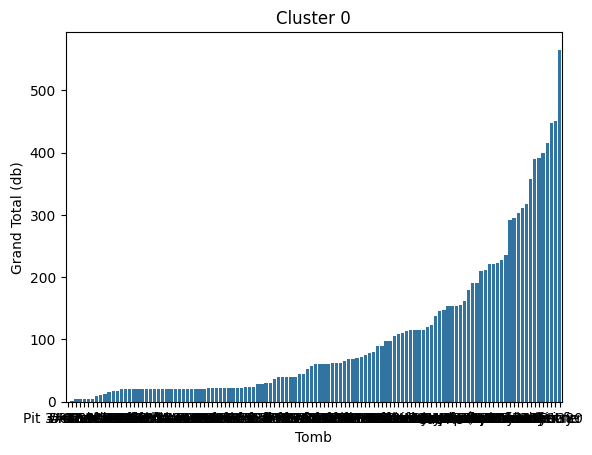

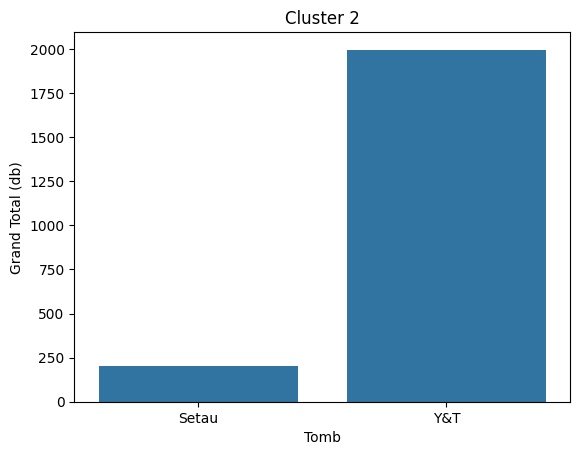

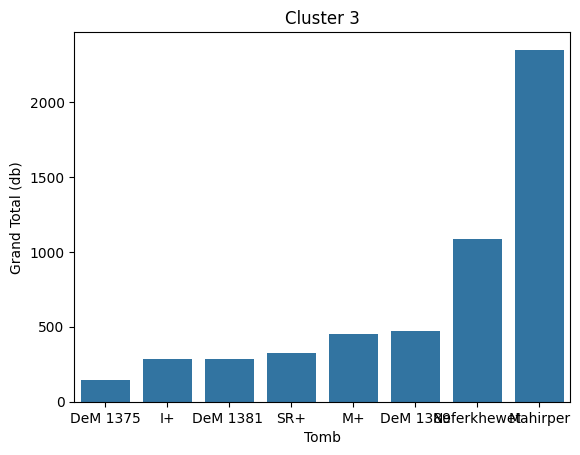

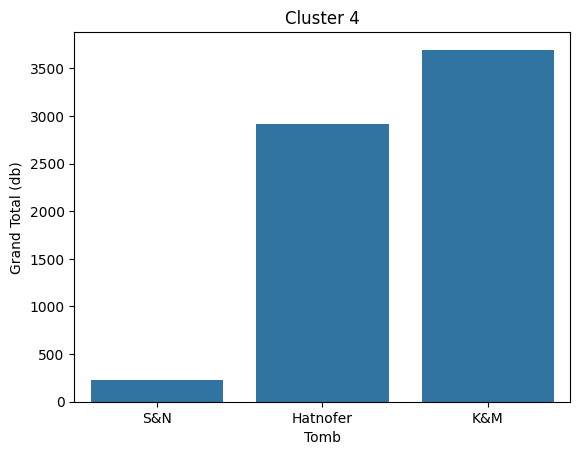

In [28]:
# plot clusters and grand_total spent
for df in df_list:
    clus_num = df["cluster"].iloc[0]
    plt.clf()
    sns.barplot(df, x="tomb", y="grand_total", order = df.sort_values("grand_total").tomb).set_title(f"Cluster {clus_num}")
    plt.xlabel("Tomb")
    plt.ylabel("Grand Total (db)")
    plt.show()


In [29]:
# investigate feature distributions in cluster dataframes
for df in df_list:
    clus_num = df["cluster"].iloc[0]
    print(f"Cluster Number {clus_num}")
    print(df.describe())

Cluster Number 0
             rank  grand_total    amphorae     bouquet       bowls  \
count  120.000000   120.000000  120.000000  120.000000  120.000000   
mean    25.183000   101.100000    0.283333    0.150000    0.691667   
std      9.752058   117.001357    2.747599    1.120099    2.455643   
min      5.000000     0.000000    0.000000    0.000000    0.000000   
25%     19.037500    20.000000    0.000000    0.000000    0.000000   
50%     27.250000    58.500000    0.000000    0.000000    0.000000   
75%     33.862500   139.750000    0.000000    0.000000    0.000000   
max     50.000000   565.500000   30.000000   12.000000   17.000000   

           boxbas     coffins   fertility    funerary  furniture       jars  \
count  120.000000  120.000000  120.000000  120.000000  120.00000  120.00000   
mean     3.250000   47.291667    0.070833   13.458333    1.92500    3.80000   
std     11.773243   35.330943    0.421561   28.408750    6.99359   17.66238   
min      0.000000    0.000000    0.0

In [30]:
# investigate proportion of grand_total spent on vessels
def ves_percent(row):
    if row["grand_total"] != 0:
        return row["vessels"] / row["grand_total"]
    else:
        return 0

for df in df_list:
    df = df.copy()
    clus_num = df["cluster"].mean()
    print(f"Cluster Number {int(clus_num)}")
    df["ves_percent"] = df.apply(ves_percent, axis=1)
    print(df["ves_percent"].mean())
    print(df["ves_percent"].max())

Cluster Number 0
0.0029658609251182505
0.20179372197309417
Cluster Number 2
0.02630260521042084
0.05260521042084168
Cluster Number 3
0.006773938305099425
0.04141739530602853
Cluster Number 4
0.3667952478752858
0.45064377682403434
